# Key-Value Attention for Thai Karaoke Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with attention mechnism that coverts names of Thai 2019 MP candidates from Thai script to Roman(Latin) script. E.g. นิยม-->niyom

The use of Pytorch Lightning is optional but recommended. You can use Pytorch if you prefer.

In [1]:
# !pip install lightning wandb
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [2]:
# !wandb login

In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')
import torch
# import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning as L
import numpy as np

import random

## Load Dataset
We have generated a toy dataset using names of Thai MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

```
ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak
```


In [4]:
# !wget https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/mp_name_th_en.csv

In [5]:
import csv

with open('mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        temp_th = row[0]
        temp_en = row[1]

        name_th.append(temp_th)
        name_en.append(temp_en)

In [6]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## TODO1: Preprocess dataset
* You will need 2 vocabularies (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding (for both input and output)
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)

In [7]:
#Preprocessing
input_chars = list(set(''.join(name_th)))
output_chars = list(set(''.join(name_en)))
data_size, vocab_size = len(name_th), len(input_chars)+1
output_vocab_size = len(output_chars)+2#+2 for special end of sentence token/PADDING
print('There are %d lines and %d unique characters in your input data.' % (data_size, vocab_size))
maxlen = len( max(name_th, key=len)) #max input length
maxlen_out = len( max(name_en, key=len)) #max input length

There are 10887 lines and 65 unique characters in your input data.


In [8]:
print("Max input length:", maxlen)
print("Max output length:", maxlen_out)

Max input length: 20
Max output length: 19


In [9]:
sorted_chars = sorted(input_chars)
sorted_output_chars = sorted(output_chars)
sorted_chars.insert(0, "<PAD>")
sorted_output_chars.insert(0, "<PAD>")
sorted_output_chars.insert(1, "<END>")

input_stoi = {c: i for i, c in enumerate(sorted_chars)}
input_itos = {i: c for i, c in enumerate(sorted_chars)}
input_encode = lambda s: [input_stoi[i] for i in s]
input_decode = lambda l: "".join([input_itos[i] for i in l])

output_stoi = {c: i for i, c in enumerate(sorted_output_chars)}
output_itos = {i: c for i, c in enumerate(sorted_output_chars)}
output_encode = lambda s: [output_stoi[i] for i in s]
output_decode = lambda l: "".join([output_itos[i] for i in l])

print(input_encode("นราวิชญ์"))
print(input_decode(input_encode("นราวิชญ์")))

[24, 34, 46, 36, 48, 9, 12, 64]
นราวิชญ์


In [10]:
print(output_itos)

{0: '<PAD>', 1: '<END>', 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'w', 23: 'y'}


In [11]:
X, Y = [], []
for line in name_th:
    line = [i for i in line]
    X.append(torch.tensor(input_encode(line)))
for line in name_en:
    line = [i for i in line]
    # out = output_encode(line).append(input_encode("<END>"))
    Y.append(torch.tensor(output_encode(line)))

X = nn.utils.rnn.pad_sequence(X, batch_first=True)
Y = nn.utils.rnn.pad_sequence(Y, batch_first=True)

In [12]:
print(X.shape)
print(X[0])
print(Y.shape)
print(Y[0])

torch.Size([10887, 20])
tensor([58,  2, 34, 39, 49, 40, 64,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0])
torch.Size([10887, 19])
tensor([12, 18,  3, 11, 19, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0])


In [13]:
from torch.utils.data import Dataset, DataLoader

In [14]:
class NameDataset(Dataset):
  def __init__(self, X, y):
    self.encoded = X.long()
    self.label = y.long()

  def __getitem__(self, idx):
    return {"x": self.encoded[idx], "y": self.label[idx]}

  def __len__(self):
    return len(self.encoded)

In [15]:
class NameDataModule(L.LightningDataModule):

    def __init__(self, train_data, y, batch_size, num_workers=0):
        super().__init__()
        self.train_data = train_data
        self.y = y
        self.batch_size = batch_size
        self.num_workers = num_workers


    def setup(self, stage: str):
        pass

    def collate_fn(self, batch):
        one_hot_x = torch.stack([F.one_hot(b["x"], num_classes=len(input_stoi)) for b in batch])
        return {"x": one_hot_x.float(), "y": torch.stack([b["y"] for b in batch])}

    def train_dataloader(self):
        train_dataset = NameDataset(self.train_data, self.y)
        train_loader = DataLoader(train_dataset,
                                  batch_size=self.batch_size,
                                  shuffle=True,
                                  collate_fn=self.collate_fn,
                                  num_workers=self.num_workers)
        return train_loader


# Attention Mechanism


## TODO 2: Code your own (key-value) attention mechnism
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* fill code for one_step_attention function



In [95]:
def one_step_attention(h, s_prev, linear_1, linear_2):
    # print(h.shape, s_prev.shape) # torch.Size([64, 20, 128]) torch.Size([64, 64])
    #Split into Key-Value
    key, value = torch.split(h, h.size(2) // 2, dim=-1)
    #do concat with s_prev.
    s_prev = s_prev.unsqueeze(1).repeat((1, h.shape[1], 1))
    concat = torch.cat([key, s_prev], dim=-1)
    #hint: you will need to use s_prev.repeat(...) somehow so that it has the same dimension as the key
    #hint2: s_prev.unsqueeze() could also be useful


    #Attention function###
    e = F.tanh(linear_1(concat))
    energies = F.relu(linear_2(e))
    # use layer(s) from your model to calculate attention_scores and then softmax
    attention_scores = F.softmax(energies, dim=1)
    # calculate a context vector
    temp = torch.mul(attention_scores, value)
    context = torch.sum(temp, dim=1)
    # print(attention_scores.shape, context.shape) # torch.Size([64, 20, 1]) torch.Size([64, 64])

    return context, attention_scores

# Translation Model

## TODO3: Create and train your encoder/decoder model here

In [96]:
# output_vocab = output_stoi
class myVocab():
    def __init__(self, output_stoi, output_itos, output_encode, output_decode):
        self.stoi = output_stoi
        self.itos = output_itos
        self.encode = output_encode
        self.decode = output_decode

    def __len__(self):
        return len(self.stoi)
    
    def lookup_tokens(self, token):
        return [self.itos[int(t)] for t in token]

In [97]:
output_vocab = myVocab(output_stoi, output_itos, output_encode, output_decode)

In [98]:
class AttentionModel(L.LightningModule):
    def __init__(self, learning_rate, criterion):

        super().__init__()
        self.n_h = 32*2 #hidden dimensions for encoder
        self.n_s = 64 #hidden dimensions for decoder

        self.learning_rate = learning_rate
        self.criterion = criterion

        #encoder can be any RNN of your choice
        bidirection = True
        self.num_directions = 2 if bidirection else 1
        self.lstm = nn.LSTM(len(input_stoi), self.n_h, bidirectional=bidirection, batch_first=True)
        #decoder has to be (any) RNNCell since we will need to calculate attention for each timestep manually
        self.decoder_lstm_cell = nn.LSTMCell(self.n_s, self.n_s)
        self.output_layer = nn.Linear(self.n_s, len(output_vocab))
        #attention
        self.linear_1 = nn.Linear(self.n_h*self.num_directions, self.n_h//2)
        self.linear_2 = nn.Linear(self.n_h//2, 1)


    def forward(self, src, return_attention=False): #use return_attention only when you want to get the attention scores for visualizing
        #pass the input to the encoder
        lstm_out, _ = self.lstm(src)

        #Initialize the LSTM states. We have to do this since we are using LSTMCell (https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html)
        #These states will get updated while we are decoding
        decoder_s = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)
        decoder_c = torch.randn(src.shape[0], self.n_s).to(self.decoder_lstm_cell.weight_ih.device)

        #Iterate until max_output_length (Decoding)
        prediction = torch.zeros((src.shape[0], maxlen_out, len(output_vocab))).to(self.decoder_lstm_cell.weight_ih.device)
        attention_scores = [] #to store the score for each step
        for t in range(maxlen_out):

            #Perform one step of the attention mechanism to calculate the context vector at timestep t
            context, attention_score = one_step_attention(lstm_out, decoder_s, self.linear_1, self.linear_2)
            attention_scores.append(attention_score)

            # Feed the context vector to the decoder.
            decoder_s, decoder_c = self.decoder_lstm_cell(context, (decoder_s, decoder_c))

            # Pass the decoder hidden output to the output layer (softmax)
            out = self.output_layer(decoder_s)

            # Put the predicted output into the list for this timestep
            prediction[:, t] = out

        return (prediction, attention_scores if return_attention else None)

    def training_step(self, batch, batch_idx):
        src = batch['x']
        target = batch['y']
        prediction,_ = self(src)
        prediction = prediction.reshape(-1, len(output_vocab))
        target = target.reshape(-1)
        loss = self.criterion(prediction, target)
        self.log("train_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        src = batch['x']
        with torch.no_grad():
          prediction, attention_scores = self(src, return_attention=True)
          prediction = F.softmax(prediction, dim=-1)
          prediction = torch.argmax(prediction, dim=-1)
          for pred in prediction:
            print("".join(output_vocab.lookup_tokens(pred.cpu().numpy())))
        return prediction, attention_scores

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

In [99]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.003
model = AttentionModel(learning_rate, criterion)

In [100]:
batch_size = 64
data_module = NameDataModule(X, Y, batch_size)

In [101]:
from lightning import Trainer
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(project="hw3.1_attention")

In [102]:
trainer = L.Trainer(
    max_epochs=200,
    # logger=wandb_logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [103]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params | Mode 
---------------------------------------------------------------
0 | criterion         | CrossEntropyLoss | 0      | train
1 | lstm              | LSTM             | 67.1 K | train
2 | decoder_lstm_cell | LSTMCell         | 33.3 K | train
3 | output_layer      | Linear           | 1.6 K  | train
4 | linear_1          | Linear           | 4.1 K  | train
5 | linear_2          | Linear           | 33     | train
---------------------------------------------------------------
106 K     Trainable params
0         Non-trainable params
106 K     Total params
0.424     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
/home/andre/anaconda3/envs/ML/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of t

Training: |          | 0/? [00:00<?, ?it/s]

torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size


Detected KeyboardInterrupt, attempting graceful shutdown ...


torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size([64, 20, 1]) torch.Size([64, 64])
torch.Size

NameError: name 'exit' is not defined

# Test Your Model

## TODO4: Test your model on 5 examples of your choice including your name!

Example Output:
```
prayutthatha</s></s>aa</s></s>a</s>
somchai</s></s></s></s>a</s></s>a</s></s></s></s></s>
thanathon</s></s></s></s></s></s></s></s></s></s></s>
newin</s>i</s></s></s></s></s></s></s></s></s></s></s></s></s>
suthep</s>he</s></s></s></s></s></s></s></s></s></s></s>
prawit</s></s></s></s></s></s></s></s></s></s></s></s></s></s>
chatchachatti</s></s>i</s></s></s></s>
```

<font color='blue'>Paste your model predictions in MyCourseVille</font>

In [107]:
# EXAMPLES = ['ประยุทธ','สมชาย','ธนาธร','เนวิน','สุเทพ','ประวิตร์','ชัชชาติ']
EXAMPLES = ['นราวิชญ์','นามสนธิ์', 'แอนดิว', 'กัญญพัชร', 'ตั้งติรวัฒน์', 'ปุยฝ้าย']
predict_data = []
for line in EXAMPLES:
    line = [i for i in line]
    predict_data.append(torch.tensor(input_encode(line)))

def collate_fn(batch):
    one_hot_x = torch.stack([F.one_hot(b["x"], num_classes=len(input_stoi)) for b in batch])
    return {"x": one_hot_x.float()}

predict_data = nn.utils.rnn.pad_sequence(predict_data, batch_first=True)
# print(predict_data.shape)
predict_data = NameDataset(predict_data, torch.stack([torch.tensor(0)]*len(predict_data)))
predict_loader = DataLoader(predict_data,
                            batch_size=1,
                            shuffle=False,
                            collate_fn=collate_fn,
                            num_workers=0)

{'x': tensor([24, 34, 46, 36, 48,  9, 12, 64,  0,  0,  0,  0]), 'y': tensor(0)}


In [47]:
model = AttentionModel.load_from_checkpoint("./lightning_logs/version_14/checkpoints/epoch=199-step=34200.ckpt", learning_rate=learning_rate, criterion=criterion)

In [48]:
model.eval()

AttentionModel(
  (criterion): CrossEntropyLoss()
  (lstm): LSTM(65, 64, batch_first=True, bidirectional=True)
  (decoder_lstm_cell): LSTMCell(64, 64)
  (output_layer): Linear(in_features=64, out_features=24, bias=True)
  (linear_1): Linear(in_features=128, out_features=32, bias=True)
  (linear_2): Linear(in_features=32, out_features=1, bias=True)
)

In [56]:
output = trainer.predict(model, predict_loader)

# for i in range(len(EXAMPLES)):
#     print(f"{EXAMPLES[i]}: {("".join(output_vocab.lookup_tokens(output[i][0][0].cpu().numpy()))).split('<')[0]}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

นราวิชญ์: narawit
นามสนธิ์: namson
แอนดิว: aandew
กัญญพัชร: kanyaphatcha
ตั้งติรวัฒน์: tangtirawat
ปุยฝ้าย: puyafai


## TODO 5: Show your visualization of attention scores on one of your example

<font color='blue'>Paste your visualization image in MyCourseVille</font>

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [105]:
idx = 4
prediction, attention_scores = zip(*(output[idx:idx+1]))
print(prediction[0].shape, len(attention_scores[0]), attention_scores[0][0].shape)
# print(len(input_stoi))

torch.Size([1, 19]) 19 torch.Size([1, 12, 1])


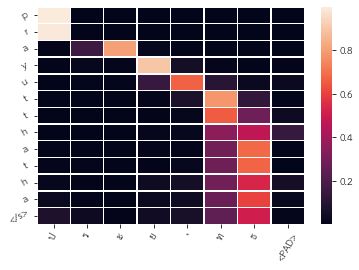

In [ ]:
ax = sns.heatmap(attn_viz, linewidth=0.5)
ax.set_yticklabels(output_text,rotation=30)
ax.set_xticklabels(xlabels,rotation=60)
plt.show()

In [112]:
# print(input_itos)
print(predict_data[0]['x'])

tensor([24, 34, 46, 36, 48,  9, 12, 64,  0,  0,  0,  0])


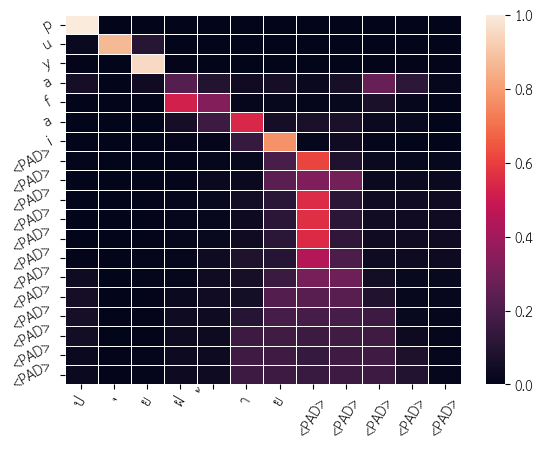

In [133]:
idx = 5
prediction, attention_scores = zip(*(output[idx:idx+1]))
# print(prediction[0].shape, len(attention_scores[0]), attention_scores[0][0].shape)

attn_viz = []
output_text = output_vocab.lookup_tokens(prediction[0][0].cpu().numpy())
# print(output_text)
xlabels = [input_itos[i] for i in predict_data[idx]['x'].cpu().numpy()]
# print(xlabels)

# print(len(attention_scores[0]))
for i in range(len(attention_scores[0])):
    attn_viz.append(attention_scores[0][i][0].cpu().numpy()[:, 0])
    # print(attention_scores[0][i][0].cpu().numpy()[:, 0].shape)

ax = sns.heatmap(attn_viz, linewidth=0.5)
ax.set_yticklabels(output_text,rotation=30)
ax.set_xticklabels(xlabels,rotation=60)
plt.show()